## Open-set in Imagenet Paper
This notebook contains the code to reproduce the figures in the paper. 
### OSCR Curves for all protocols


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_models_epochs(file_dict):
    row = []
    for alias, file_path in file_dict.items():
        folder = str(file_path).split('/')[:-1]
        ckp1 = '/'.join(folder)+'/'+folder[-1]+'_best.pth'
        if alias == "$S_2$":
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_119.pth'
        else:
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_curr.pth'
        epoch1 = util.get_checkpoint_epoch(ckp1)
        epoch2 = util.get_checkpoint_epoch(ckp2)
        row.append((alias, epoch1, epoch2))
    return pd.DataFrame(row, columns =['Name', 'best', 'curr'])


def get_confidence(scores, targets):
    targets = targets.astype(int)
    kn = targets >= 0
    ku = targets == -1
    uu = targets == -2
    C = scores.shape[1]
    weights = np.array([sum(kn), sum(ku), sum(uu)])/C
    ckk = np.mean(scores[kn,targets[kn]])
    cku = np.mean(1 - np.amax(scores[ku], axis=1) + 1/C)
    
    if sum(uu) != 0:
        cuu = np.mean(1 - np.amax(scores[uu], axis=1) + 1/C)
        c_mean = np.average(np.array([ckk, cku, cuu]), weights=weights)
    else:
        c_mean = np.average(np.array([ckk, cku]), weights=weights[:-1])
        cuu = -1
    return ckk, cku, cuu, c_mean

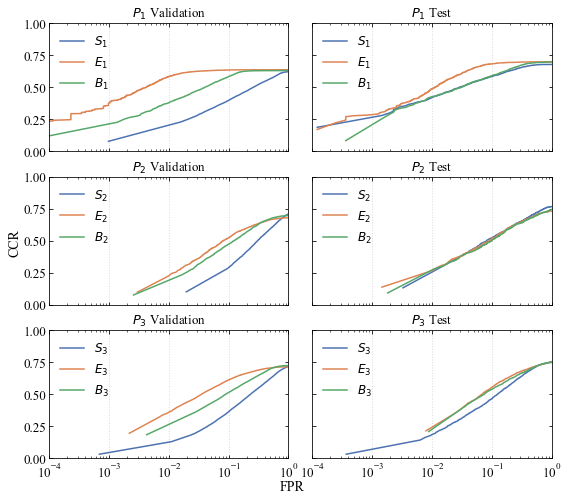

In [1]:
import sys
sys.path.append("../")
import src.util as util
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["font.family"] = "Times New Roman"

# General Experiments
results = Path('../../results')
outputs = Path('../outputs/')
old = Path('../outputs/old')

p1_paths = {
    '$S_{1}$':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_val_arr.npz',
    '$E_{1}$':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_val_arr.npz',
    '$B_{1}$':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_val_arr.npz',
    }

p2_paths = {    
    '$S_{2}$':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_val_arr.npz',
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_val_arr.npz',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_val_arr.npz',
    }

p3_paths = {    
    '$S_{3}$':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_val_arr.npz',
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_val_arr.npz',    
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_val_arr.npz',
   }

p1_val = util.read_array_list(p1_paths)
p1_test = util.read_array_list(util.transform_to_test(p1_paths))

p2_val = util.read_array_list(p2_paths)
p2_test = util.read_array_list(util.transform_to_test(p2_paths))

p3_val = util.read_array_list(p3_paths)
p3_test = util.read_array_list(util.transform_to_test(p3_paths))

points = 10000
font = 14
scale = 'semilog'
fig = plt.figure(figsize=(9,8))  
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)
axs = axs.flat

util.plot_oscr(arrays=p1_val, scale=scale, title='$P_1$ Validation', ax_label_font=13, ax=axs[0],
              legend_pos="upper left", unk_label=-1, points=points)

util.plot_oscr(arrays=p1_test, scale=scale, title='$P_1$ Test', ax_label_font=13, ax=axs[1],
              legend_pos="upper left", unk_label=-2, points=points)

util.plot_oscr(arrays=p2_val, scale=scale, title='$P_2$ Validation', ax_label_font=13, ax=axs[2],
              legend_pos="upper left", unk_label=-1, points=points)

util.plot_oscr(arrays=p2_test, scale=scale, title='$P_2$ Test', ax_label_font=13, ax=axs[3],
              legend_pos="upper left", unk_label=-2, points=points)

util.plot_oscr(arrays=p3_val, scale=scale, title='$P_3$ Validation', ax_label_font=13, ax=axs[4],
              legend_pos="upper left", unk_label=-1, points=points)

util.plot_oscr(arrays=p3_test, scale=scale, title='$P_3$ Test', ax_label_font=13, ax=axs[5],
              legend_pos="upper left", unk_label=-2, points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.07, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/oscr_all_protocols.pdf', dpi=90, bbox_inches='tight')
plt.show()

### Confidence Metrics

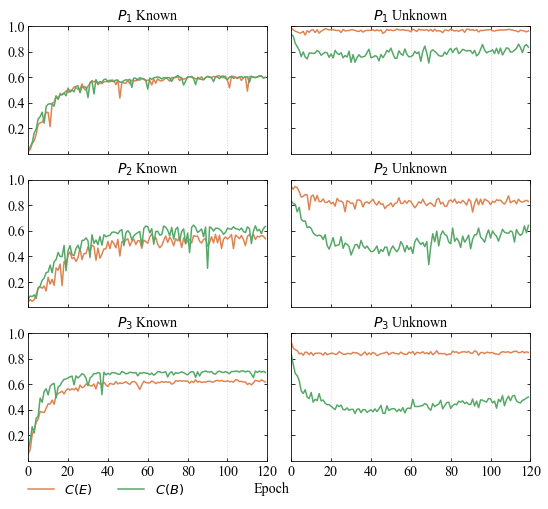

In [49]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

outputs = Path('../outputs/')

event_paths = {    
    '$E_{1}$':  outputs / 'e1n_l1_e0_adam/events.out.tfevents.1655681577.rolf.252847.0',    
    '$B_{1}$':  outputs / 'b1n_l1_e0_adam/events.out.tfevents.1655681314.rolf.247397.0',
    
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/events.out.tfevents.1655681413.rolf.249030.0',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/events.out.tfevents.1655681057.rolf.239916.0',
    
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/events.out.tfevents.1655711400.rolf.249245.0',
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/events.out.tfevents.1655681621.rolf.253932.0',
   }


linewidth = 1.5
legend_pos = "lower right"
font_size = 14
colors = sns.color_palette("deep")
colors2 = sns.color_palette("deep")
fig = plt.figure(figsize=(9,8))  
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

for ix, (exp_name, f_path)  in enumerate(event_paths.items()):  
    ax_kn = axs[2 * (ix//2)]
    ax_unk = axs[2 * (ix//2) + 1]
    # Read data from the tensorboard object  
    event_acc = EventAccumulator(str(f_path), size_guidance={'scalars': 0})
    event_acc.Reload()
    
    # Plot known confidence
    _, step_kn, val_kn = zip(*event_acc.Scalars('val/conf_kn'))
    ax_kn.plot(step_kn, val_kn, linewidth=linewidth, label = exp_name + ' kn', color=colors[ix%2 + 1])
    
    # Plot unknown confidence
    _, step_unk, val_unk = zip(*event_acc.Scalars('val/conf_unk'))
    ax_unk.plot(step_unk, val_unk, linewidth=linewidth, label = exp_name + ' unk', color=colors2[ix%2 + 1], )
    
    #  set axis properties
    ax_kn.set_title("$P_{}$ Known".format(ix//2 + 1), fontsize=font_size)
    ax_unk.set_title("$P_{}$ Unknown".format(ix//2 + 1), fontsize=font_size)

# Manual legend
# axs[-1].legend(['$C(E)$', '$C(B)$'], frameon=False, fontsize=font_size - 1, 
#                bbox_to_anchor=(0.9, -0.07), ncol=2)
axs[-2].legend(['$C(E)$', '$C(B)$'], frameon=False, fontsize=font_size - 1, 
               bbox_to_anchor=(0.7, -0.07), ncol=2)

for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                   labelright=False, labelsize=font_size)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 1)
    # Thicklocator parameters
    ax.yaxis.set_major_locator(MaxNLocator(5, prune='lower'))
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
# X label
fig.text(0.5, 0.07, 'Epoch', ha='center', fontsize=font_size)
plt.savefig('fig/confidence.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [69]:
from robustness.tools.imagenet_helpers import ImageNetHierarchy, common_superclass_wnid
from pathlib import Path
im_info_path = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012/robustness")
root_dir = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012")
hierarchy = ImageNetHierarchy(root_dir, im_info_path)


def get_descendants_wid(hier, node_wn_id, in_imagenet=True):
        if in_imagenet:
            return sorted([ww for ww in hier.tree[node_wn_id].descendants_all
                           if ww in set(hier.in_wnids)])
        else:
            return sorted(list(hier.tree[node_wn_id].descendants_all))
        
def print_parents(tree, wnid):
    parent_id = tree[wnid].parent_wnid
    if parent_id is None:
        return 0
    print(tree[parent_id])
    print_parents(tree, parent_id)    
    
def print_descendants(hier, wid):
    des = get_descendants_wid(hier, wid, False)
    for i in des:
        print(hier.tree[i])


In [72]:
print_descendants(hierarchy, 'n07555863')

Name: (baked goods), ImageNet Class: (-1), Descendants: (3)
Name: (bread, breadstuff, staff of life), ImageNet Class: (-1), Descendants: (3)
Name: (bun, roll), ImageNet Class: (-1), Descendants: (1)
Name: (cracker), ImageNet Class: (-1), Descendants: (1)
Name: (loaf of bread, loaf), ImageNet Class: (-1), Descendants: (1)
Name: (French loaf), ImageNet Class: (930), Descendants: (0)
Name: (bagel, beigel), ImageNet Class: (931), Descendants: (0)
Name: (pretzel), ImageNet Class: (932), Descendants: (0)
Name: (produce, green goods, green groceries, garden truck), ImageNet Class: (-1), Descendants: (21)
Name: (edible fruit), ImageNet Class: (-1), Descendants: (9)
Name: (vegetable, veggie, veg), ImageNet Class: (-1), Descendants: (12)
Name: (solanaceous vegetable), ImageNet Class: (-1), Descendants: (1)
Name: (cruciferous vegetable), ImageNet Class: (-1), Descendants: (3)
Name: (cabbage, chou), ImageNet Class: (-1), Descendants: (1)
Name: (head cabbage), ImageNet Class: (936), Descendants: (0

In [73]:
# dog = 'n02084071'
# hun_dog = 'n02087122'

# kn_superclasses = [dog]
# kn_superclasses = ['n02084071', 'n02087122']
# kn_unk_superclasses = ['n02118333', 'n02115335', 'n02114100', 'n02120997',
#                                         'n02131653', 'n02441326', 'n02370806', 'n02469914']
unk_unk_superclasses = ['n02085374', 'n02118333', 'n02115335', 'n02114100',
                                         'n02120997', 'n02131653', 'n02441326', 'n02370806']

# print('Known superclass')
# for id in kn_superclasses:
#     print_parents(hierarchy.tree, id)
#     print('\n')
    
# print('Kn_unk superclass')
# for id in kn_unk_superclasses:
#     print_parents(hierarchy.tree, id)
#     print('\n')

print('unk_unk superclass')
for id in ['n07555863']:
    print_parents(hierarchy.tree, id)
    print('\n')



unk_unk superclass
Name: (solid), ImageNet Class: (-1), Descendants: (24)
Name: (matter), ImageNet Class: (-1), Descendants: (43)
Name: (physical entity), ImageNet Class: (-1), Descendants: (992)
Name: (entity), ImageNet Class: (-1), Descendants: (1000)




In [67]:


hun_dog in hierarchy.in_wnids

False

In [65]:
for i in hierarchy.tree['n02084071'].descendants_all:

{'n02085374',
 'n02085620',
 'n02085782',
 'n02085936',
 'n02086079',
 'n02086240',
 'n02086346',
 'n02086478',
 'n02086646',
 'n02086910',
 'n02087046',
 'n02087122',
 'n02087394',
 'n02087551',
 'n02088094',
 'n02088238',
 'n02088364',
 'n02088466',
 'n02088632',
 'n02088839',
 'n02089078',
 'n02089555',
 'n02089867',
 'n02089973',
 'n02090379',
 'n02090475',
 'n02090622',
 'n02090721',
 'n02091244',
 'n02091467',
 'n02091635',
 'n02091831',
 'n02092002',
 'n02092339',
 'n02092468',
 'n02093056',
 'n02093256',
 'n02093428',
 'n02093647',
 'n02093754',
 'n02093859',
 'n02093991',
 'n02094114',
 'n02094258',
 'n02094433',
 'n02095050',
 'n02095314',
 'n02095412',
 'n02095570',
 'n02095727',
 'n02095889',
 'n02096051',
 'n02096177',
 'n02096294',
 'n02096437',
 'n02096585',
 'n02096756',
 'n02097047',
 'n02097130',
 'n02097209',
 'n02097298',
 'n02097474',
 'n02097658',
 'n02098105',
 'n02098286',
 'n02098413',
 'n02098550',
 'n02099029',
 'n02099267',
 'n02099429',
 'n02099601',
 'n020